Testing if the Molecule Diffusion Model Works:


In [1]:
# Changes working directory to root to allow imports to work

import os

def change_directory_to_root(root_name: str = "GDProject"):
    """Changes the directory to the root of the project"""
    current_folder = os.getcwd().split('/')[-1]
    if current_folder != root_name:
        os.chdir('..')

    print(f"New Current Directory is {os.getcwd()}")

change_directory_to_root()

New Current Directory is /home/alden/Research/GDProject


In [2]:
# Supress pytorch pickle load warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# Library imports
import gdiffusion as gd
import util
import util.chem as chem
import util.visualization as vis
import util.stats as gdstats

from gdiffusion.classifier.logp_predictor import LogPPredictor
# Paths for all of the models:
from util.model_paths import *

device = util.get_device(print_device=True)

Device: cuda


In [19]:
# Load Diffusion
molecule_diffusion_model = gd.MoleculeDiffusionModel(unet_state_dict_path=MOLECULE_DIFFUSION_MODEL_PATH, device=device)
diffusion_ddim = gd.DDIMSampler(diffusion_model=molecule_diffusion_model, sampling_timesteps=50)
diffusion_ddpm =  gd.DDPMSampler(diffusion_model=molecule_diffusion_model)

[Molecule Diffusion]: UNet Successfully loaded
- Total parameters: 57,314,049
- Trainable parameters: 57,314,049
- Model size: 218.6 MB


Test if diffusion works normally

In [11]:
# Test if diffusion works normally:
z_diffusion_cached = diffusion_ddpm.sample(batch_size=64)

DDPM Sampling Loop Time Step: 100%|██████████| 1000/1000 [00:22<00:00, 43.87it/s]


Test Guided Diffusion

DDPM Sampling Loop Time Step: 100%|██████████| 1000/1000 [00:09<00:00, 100.70it/s]


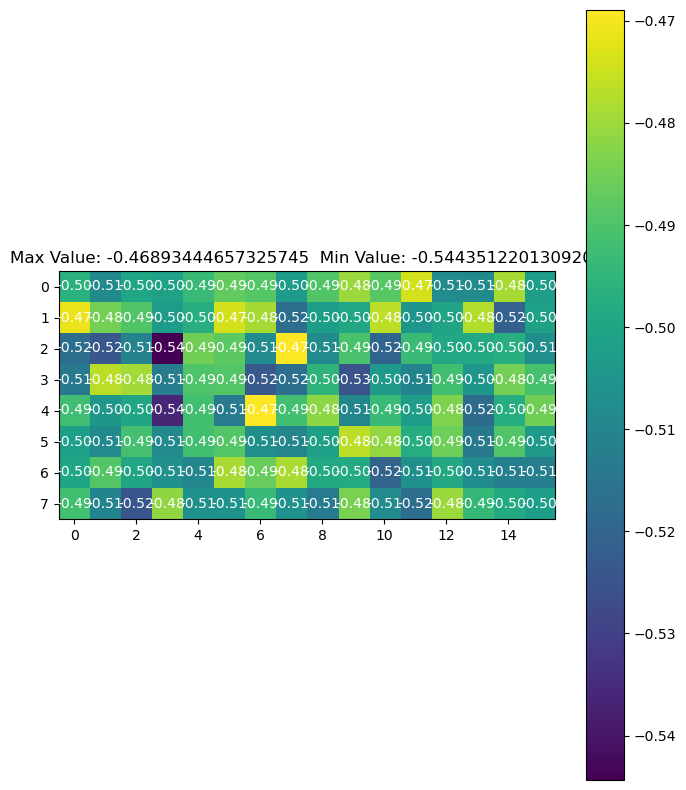

In [12]:
# DDPM - Test Diffusion Can get all latent values to be 0.5

cond_fn_normal_dist = gd.get_cond_fn_normal_analytical(mean=-0.5, sigma=0.01)
z = diffusion_ddpm.sample(batch_size=16, cond_fn=cond_fn_normal_dist)

# Should be normal centered around 0.2
vis.display_latent(z[0])


DDIM Sampling Loop Time Step: 100%|██████████| 250/250 [00:02<00:00, 100.49it/s]


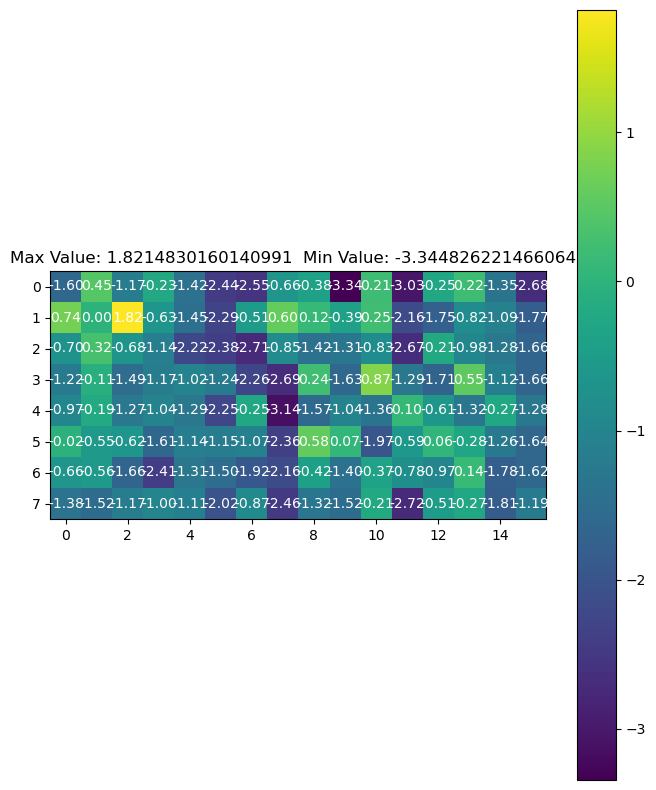

In [13]:
# DDIM - Test Diffusion Can get all latent values to be 0.5

cond_fn_normal_dist = gd.get_cond_fn_normal_analytical(mean=-0.5, sigma=0.01)
z = diffusion_ddim.sample(batch_size=16, cond_fn=cond_fn_normal_dist, guidance_scale=0.25)

# Should be normal centered around 0.2
vis.display_latent(z[0])

# DDIM is broken and does not work

In [ ]:
# Load VAE and classifier
vae = gd.MoleculeVAE()
logp_predictor : LogPPredictor = torch.load(LOGP_PREDICTOR_PATH, weights_only=False).to(device)


 Loading Molecule VAE:
------------------------------------------------
Loaded VAE Vocab from saved_models/selfies_vae/vocab.json
Getting State Dict...
Loading model from saved_models/selfies_vae/selfies-vae.ckpt
Enc params: 1,994,592
Dec params: 277,346
------------------------------------------------



DDPM Sampling Loop Time Step: 100%|██████████| 1000/1000 [00:24<00:00, 41.43it/s]


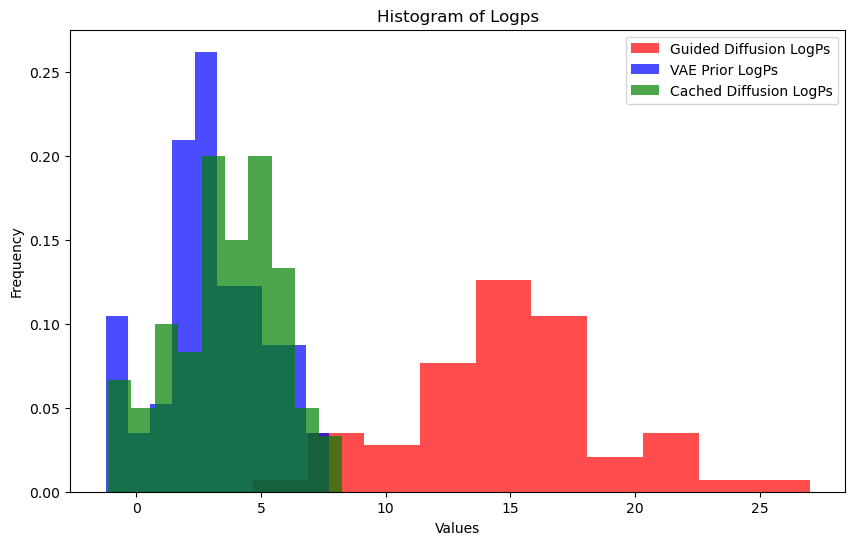

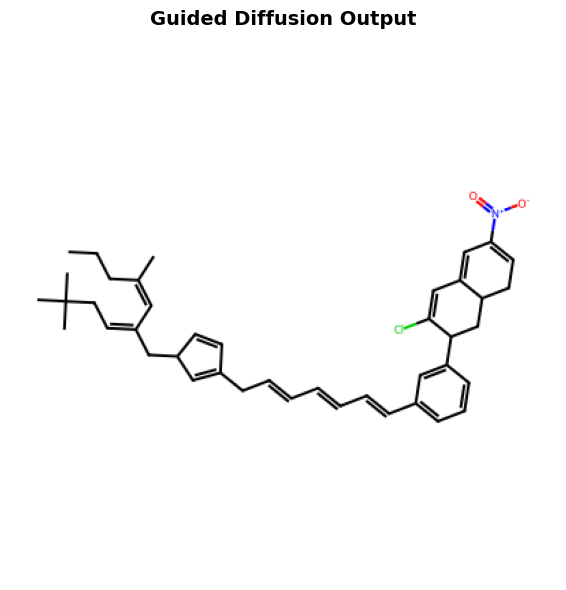

SMILES: CC(C)(C)CC=C(C=C(C)CCC)CC1C=C(C=C1)CC=CC=CC=CC2=CC=CC(=C2)C3CC4CC=C([N+1](=O)[O-1])C=C4C=C3Cl
LogP Stats: 
Max LogP: 27.02
Min LogP: 4.66
Avg LogP: 14.87

Stats:
Sample of shape: torch.Size([64, 128]) is different from other with p=0.0000

Minimum VAE Value: -5.33
Maximum VAE Value: 4.85


In [20]:
# Diffusion Test #2 and #3
# The goal is to get the shapes to work (this is just a shape test)

logp_distribution = Normal(loc=100.0, scale=1.0)

# log probability function that gives the probability of the logps of z
# under the logp_distribution

def log_prob_fn_logp(z):
    # We cant backprop thru the evaluate_logp function, so we 
    # instead have this predictor trained on latent, logp pairs:
    pred_logp = logp_predictor(z)

    # get the log_probability under the normal distribution with mean=20.0
    log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)

    # the log probability must be a single value
    assert(log_prob.shape == (1, ))
    return log_prob


# Pass random data through to check shapes work
z_random = torch.randn(16, 1, 128, device=device)

cond_fn_logp = gd.get_cond_fn(
    log_prob_fn=log_prob_fn_logp, 
    latent_dim=128,
    guidance_strength=1.0, 
    clip_grad=True, 
    clip_grad_max=1.0,
)

grad_log_prob = cond_fn_logp(mean = z_random, t = 0)
assert(z_random.shape == grad_log_prob.shape)

# Diffusion Test #3
# Try and guide the diffusion to a high LogP molecule:
z = diffusion_ddpm.sample(batch_size=64, cond_fn=cond_fn_logp)
vis.display_logp_info(z, z_diffusion_cached=z_diffusion_cached, vae=vae) # legacy function

print(f"Minimum VAE Value: {z.flatten().min():.2f}")
print(f"Maximum VAE Value: {z.flatten().max():.2f}")


DDIM Sampling Loop Time Step: 100%|██████████| 50/50 [00:01<00:00, 38.99it/s]


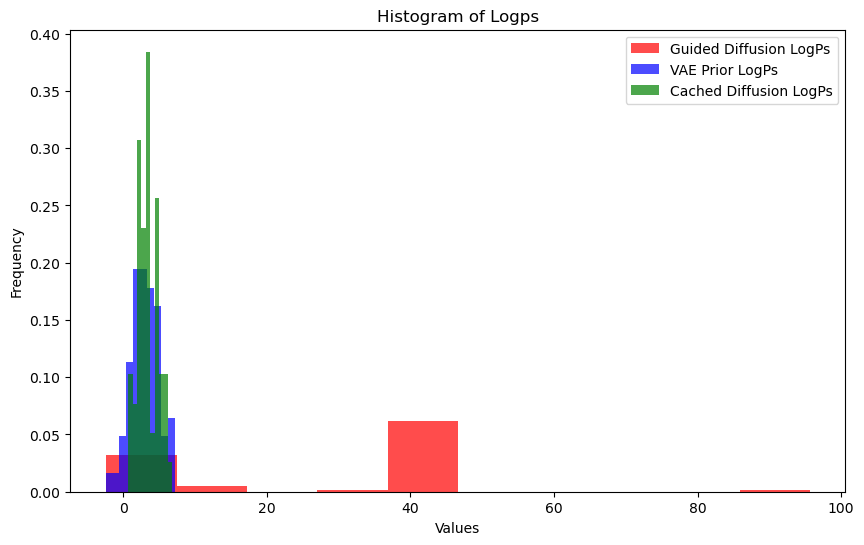

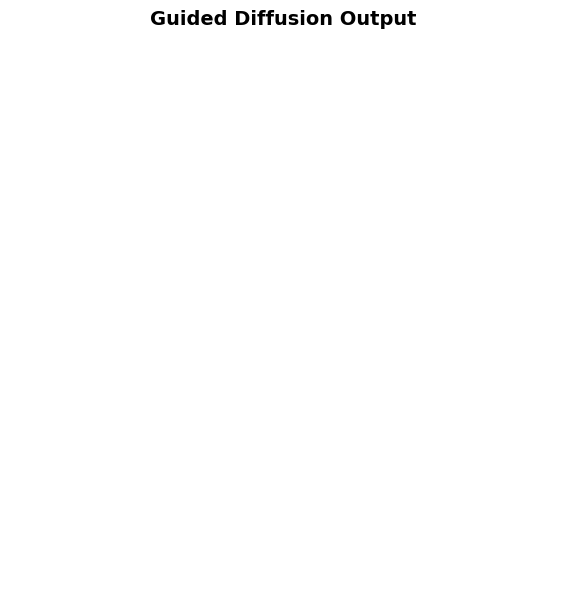

SMILES: 
LogP Stats: 
Max LogP: 95.67
Min LogP: -2.34
Avg LogP: 27.11

Stats:
Sample of shape: torch.Size([64, 128]) is different from other with p=0.0000



In [ ]:
# LogP Test to check model is working
# DDIM is basically cheating...

logp_distribution = Normal(loc=100.0, scale=1.0)
def log_prob_fn_logp(z):
    z = torch.clamp(z, -3.0, 3.0)
    pred_logp = logp_predictor(z)
    log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)
    assert(log_prob.shape == (1, ))
    return log_prob

cond_fn_logp = gd.get_cond_fn(
    log_prob_fn=log_prob_fn_logp, 
    latent_dim=128,
    clip_grad=False
)

z_diffusion_cached_ddim= diffusion_ddim.sample(batch_size=64)
z = diffusion_ddim.sample(batch_size=64, cond_fn=cond_fn_logp)
vis.display_logp_info(z, z_diffusion_cached=z_diffusion_cached_ddim, vae=vae)


DDIM Sampling Loop Time Step:   0%|          | 0/250 [00:00<?, ?it/s]

DDIM Sampling Loop Time Step: 100%|██████████| 250/250 [00:05<00:00, 44.27it/s]


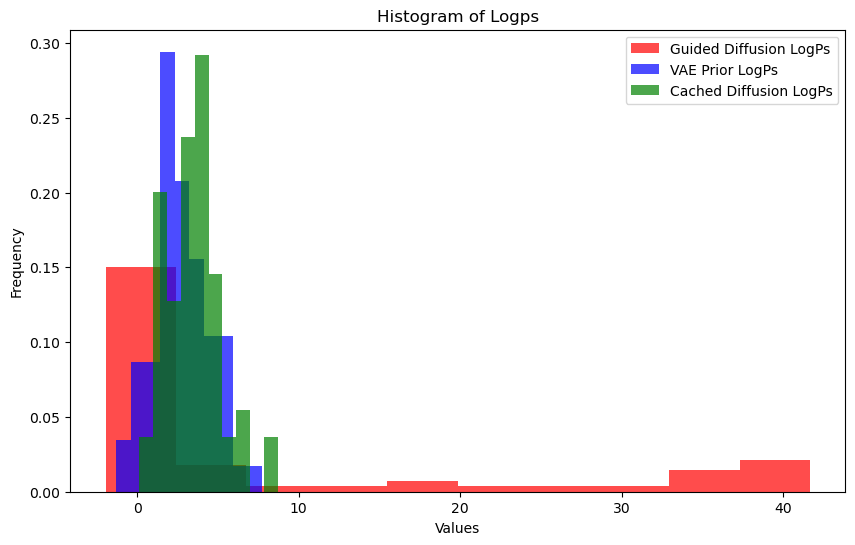

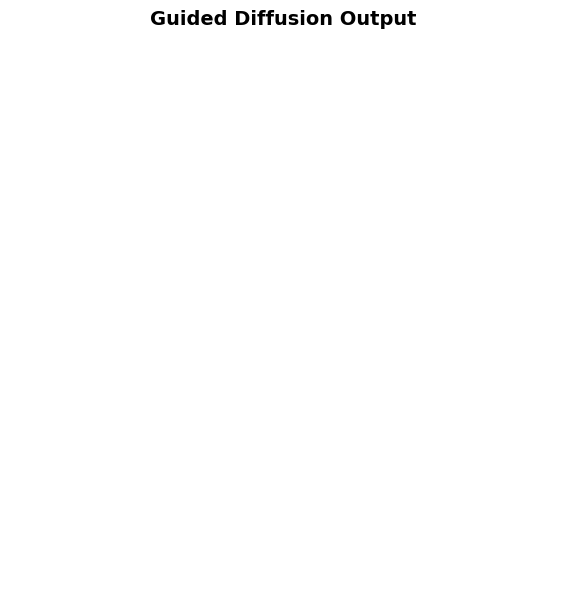

SMILES: 
LogP Stats: 
Max LogP: 41.67
Min LogP: -1.97
Avg LogP: 8.54

Stats:
Sample of shape: torch.Size([64, 128]) is different from other with p=0.0000

Minimum VAE Value: -16.18
Maximum VAE Value: 16.11


In [16]:
# Diffusion Test #2 and #3
# The goal is to get the shapes to work (this is just a shape test)

logp_distribution = Normal(loc=100.0, scale=1.0)

# log probability function that gives the probability of the logps of z
# under the logp_distribution

def log_prob_fn_logp(z):
    # We cant backprop thru the evaluate_logp function, so we 
    # instead have this predictor trained on latent, logp pairs:
    pred_logp = logp_predictor(z)

    # get the log_probability under the normal distribution with mean=20.0
    log_prob = logp_distribution.log_prob(pred_logp).sum(dim=0)

    # the log probability must be a single value
    assert(log_prob.shape == (1, ))
    return log_prob


# Pass random data through to check shapes work
z_random = torch.randn(16, 1, 128, device=device)

cond_fn_logp = gd.get_cond_fn(
    log_prob_fn=log_prob_fn_logp, 
    latent_dim=128,
    guidance_strength=1.0, 
    clip_grad=True, 
    clip_grad_max=1.0,
)

grad_log_prob = cond_fn_logp(mean = z_random, t = 0)
assert(z_random.shape == grad_log_prob.shape)

# Diffusion Test #3
# Try and guide the diffusion to a high LogP molecule:
z = diffusion_ddim.sample(batch_size=64, cond_fn=cond_fn_logp, guidance_scale=4.0)
vis.display_logp_info(z, z_diffusion_cached=diffusion_ddim.sample(batch_size=64), vae=vae) # legacy function

print(f"Minimum VAE Value: {z.flatten().min():.2f}")
print(f"Maximum VAE Value: {z.flatten().max():.2f}")
